## Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/rupali/Documents/Master Thesis/jenga')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from jenga.basis import Dataset

In [3]:
dataset = Dataset("acute-inflammations")

all_data = dataset.all_data
attribute_names = dataset.attribute_names
attribute_types = dataset.attribute_types

categorical_columns = dataset.categorical_columns
numerical_columns = dataset.numerical_columns

print(f"Found {len(categorical_columns)} categorical and {len(numerical_columns)} numeric features \n")

Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 



### Visualize the dataset

In [13]:
## plot the original dataset
def hide_current_axis(*args, **kwds):
        plt.gca().set_visible(False)
        
def plot_data(data):
    sns.set_style("white") # grid/no grid style: darkgrid, whitegrid, dark, white, ticks
    
    plot = sns.pairplot(data, hue="class")
    plot.map_upper(hide_current_axis)
    plt.show()

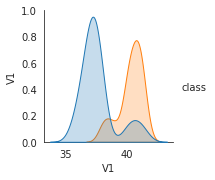

In [14]:
plot_data(all_data)

### Get training and test sets

In [4]:
train_data, train_labels, test_data, test_labels = dataset.get_train_test_data(0.3)

In [30]:
## use categorical columns as strings
def cat_cols_to_str(df):
    for col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype(str)

    return df

In [31]:
train_data = cat_cols_to_str(train_data)
test_data = cat_cols_to_str(test_data)

## Model

### Model using AutoGluon

In [16]:
import autogluon as ag
from autogluon import TabularPrediction as task

label_col = 'class'

tr_data = train_data
tr_data[label_col] = train_labels

model = task.fit(train_data=tr_data, label=label_col)

# predictions
y_pred = model.predict(test_data)

# predictor performance
perf = model.evaluate_predictions(y_true=test_labels, y_pred=y_pred, auxiliary_metrics=True)

ModuleNotFoundError: No module named 'autogluon'

In [ ]:
import random
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import autogluon as ag
from autogluon import TabularPrediction as task


class Model:

  def __init__(self, seed, train_data, train_labels, test_data, test_labels, pipeline, learner, param_grid):

    ## fix random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    ## train and test data and labels
    self.train_data = train_data
    self.train_labels = train_labels
    self.test_data = test_data
    self.test_labels = test_labels
    
    ## preprocessing pipeline
    self.pipeline = pipeline
    
    ## information for model parameters
    self.learner = learner
    self.param_grid = param_grid
    
  
  def __repr__(self):
    return f"{self.__class__.__name__}: {self.__dict__}"
  
  
  # method for training a model on the raw data with preprocessing
  def fit_model(self):

    if self.learner == 'autogluon':
      label_col = 'class'
      
      tr_data = self.train_data
      tr_data[label_col] = self.train_labels
      
      model = task.fit(train_data=tr_data, label=label_col)

      return model
    else:
      grid_search = GridSearchCV(self.pipeline, self.param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
      model = grid_search.fit(self.train_data, self.train_labels)

      return model

  # method for computing evaluation scores
  def eval_scores(self, model):
    if self.learner == 'autogluon':
      # predictions
      y_pred = model.predict(self.test_data)
      
      # predictor performance
      perf = model.evaluate_predictions(y_true=self.test_labels, y_pred=y_pred, auxiliary_metrics=True)
      
      return perf
    else:
      pred_prob = model.predict_proba(self.test_data)
      roc_auc_acore = roc_auc_score(self.test_labels, np.transpose(pred_prob)[1])
      
      return roc_auc_acore
    

In [ ]:
## define preprocessing pipeline if not given
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

def get_pipeline(learner):
  # preprocessing pipeline for numerical columns
  transformer_numeric = Pipeline([
      ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
      ('standard_scale', StandardScaler())
  ])

  # preprocessing pipeline for categorical columns
  transformer_categorical = Pipeline([
      ('imputer', SimpleImputer(strategy='constant', fill_value='__NA__')),
      ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
  ])

  # preprocessor
  feature_transform = ColumnTransformer(transformers=[
      ('categorical_features', transformer_categorical, categorical_columns),
      ('numerical_features', transformer_numeric, numerical_columns)
  ])

  ## prediction pipeline: append classifier (learner) to the preprocessing pipeline
  pipeline = Pipeline([
      ('features', feature_transform),
      ('learner', learner)
  ])

  return pipeline

In [ ]:
# test autogluon
# pipeline in the case of autogluon is not used so anything is given
model_obj = Model(seed, train_data, train_labels, test_data, test_labels, get_pipeline(SGDClassifier(loss='log')), learner="autogluon", param_grid={})
model = model_obj.fit_model()
scores = model_obj.eval_scores(model)

In [ ]:
## model parameters
## models is a dict where key = leaner & value = param_grid
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

models = {SGDClassifier(loss='log'): {'learner__max_iter': [500, 1000, 5000], 
                                         'learner__penalty': ['l2', 'l1', 'elasticnet'], 
                                         'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
                                        }, 
          RandomForestClassifier():{'learner__n_estimators': [100, 200, 500], 
                                    'learner__max_depth': [5, 10, 15]
                                   },
          "autogluon": {}
         }

In [ ]:
for learner, param_grid in models.items():
  print(learner, param_grid)

In [ ]:
model_summary = []
scores_summary = []

for learner, param_grid in models.items():
  pipeline = None
  
  if learner == 'autogluon':
    pipeline = get_pipeline(SGDClassifier(loss='log'))
  else:
    pipeline = get_pipeline(learner)
  
  model_obj = Model(seed, train_data, train_labels, test_data, test_labels, pipeline, learner, param_grid)
  
  model = model_obj.fit_model()
  model_summary.append(model)

  scores = model_obj.eval_scores(model)
  scores_summary.append(scores)

In [ ]:
model_summary

In [ ]:
scores_summary

## Corruptions

In [ ]:
from jenga.corruptions.perturbations import Perturbation

In [ ]:
from jenga.corruptions.generic import MissingValues, SwappedValues, CategoricalShift
from jenga.corruptions.numerical import Scaling, GaussianNoise

In [ ]:
fraction = 0.5

In [ ]:
# corruption perturbations to apply
corr_perturbations = Perturbation(categorical_columns, numerical_columns)

### Testing Corruptions Individually

In [ ]:
corruption = [MissingValues]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruption, fraction)

In [ ]:
corruption = [SwappedValues]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruption, fraction)

In [ ]:
corruption = [CategoricalShift]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruption, fraction)

In [ ]:
corruption = [Scaling]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruption, fraction)

In [ ]:
corruption = [GaussianNoise]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruption, fraction)

### Together

In [ ]:
corruptions = [MissingValues, SwappedValues, CategoricalShift, Scaling, GaussianNoise]
fraction = 0.5

In [ ]:
corruption = [MissingValues]
test_data_corrupted, perturbations, cols_perturbed, summary_col_corrupt = corr_perturbations.apply_perturbation(test_data, corruptions, fraction)

### Visualize the original and corrupted test set

In [ ]:
## original test data
plot_data(pd.concat([test_data, pd.Series(test_labels, name='class')], axis=1))

In [ ]:
## corrupted test data
plot_data(pd.concat([test_data_corrupted, pd.Series(test_labels, name='class')], axis=1))

## Model & Corruptions using PPP

In [5]:
from sklearn.linear_model import SGDClassifier

learner = SGDClassifier(loss='log')
param_grid = {
    'learner__max_iter': [500, 1000, 5000],
    'learner__penalty': ['l2', 'l1', 'elasticnet'], 
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

In [6]:
from jenga.corruptions.generic import MissingValues, SwappedValues, CategoricalShift
from jenga.corruptions.numerical import Scaling, GaussianNoise

## Always place SwappedValues corruption after the numeric ones (Scaling, Gaussian) because the column that was selected for Swapping Values could also be used for Scaling later, but when this happens, the categorical valus can't be scaled
corruptions = [MissingValues, CategoricalShift, Scaling, GaussianNoise, SwappedValues]
fraction = 0.5
num_repetitions = 5

In [7]:
from jenga.cleaning.ppp import PipelinePerformancePrediction

ppp = PipelinePerformancePrediction(train_data, train_labels, test_data, test_labels, categorical_columns, numerical_columns, learner, param_grid)
ppp_model = ppp.fit_ppp(train_data)

## generate corrpted data
for _ in range(num_repetitions):
    df_corrupted, perturbations, cols_perturbed, summary_col_corrupt = ppp.get_corrupted(test_data, corruptions, fraction, num_repetitions)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Generating corrupted training data on 36 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.5, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: SwappedValues: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MNAR', 'swap_with': None}


ValueError: Cannot setitem on a Categorical with a new category, set the categories first

## Cleaning

### Cleaning using AutoEncoders?

In [ ]:
!pip install dfencoder

In [ ]:
from dfencoder import AutoEncoder

In [ ]:
model = AutoEncoder(encoder_layers=[512, 512, 512], 
                    decoder_layers=[], 
                    activation='relu', 
                    lr=0.01, 
                    lr_decay=0.99, 
                    batch_size=512, 
                    logger='ipnyb', 
                    verbose=False, 
                    optimizer='sgd', 
                    scaler='gauss_rank', 
                    min_cats=3)

In [ ]:
model.fit(train_data, epochs=1000, val=test_data)

### Cleaning using AutoGluon

In [ ]:
from autogluon import TabularPrediction as task

In [ ]:
def cat_cols_to_str(df):
  for col in df.columns:
    if pd.api.types.is_categorical_dtype(df[col]):
      df[col] = df[col].astype(str)

  return df

In [ ]:
train_data = cat_cols_to_str(train_data)
df_corrupted = cat_cols_to_str(df_corrupted)
test_data = cat_cols_to_str(test_data)

In [ ]:
categorical_precision_threshold = 0.7
numerical_std_error_threshold = 2

#### Training

In [ ]:
predictors = {}
predictable_cols = {}

In [ ]:
for col in categorical_columns:
  predictors[col] = task.fit(train_data=train_data, label=col, problem_type='multiclass')

  y_test = test_data[col].dropna() # take only the non-nan records # test_data? OR split the train_data again into train and test
  y_pred = predictors[col].predict(test_data.drop([col], axis=1)) # drop the actual column before predicting

  perf = predictors[col].evaluate_predictions(y_test, y_pred, auxiliary_metrics=True)

  labels = [k for k in perf['classification_report'].keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]

  high_precision_labels = []
  for label in labels:
    if perf['classification_report'][label]['precision'] > categorical_precision_threshold:
      high_precision_labels.append(label)

  if high_precision_labels:
    # predictable_cols.append(col)
    # predictors[col].high_precision_labels = high_precision_labels
    predictable_cols[col] = high_precision_labels


In [ ]:
for col in numerical_columns:
  predictors[col] = task.fit(train_data=train_data, label=col, problem_type='regression')

  y_test = test_data[col].dropna() # take only the non-nan records # test_data? OR split the train_data again into train and test
  y_pred = predictors[col].predict(test_data.drop([col], axis=1)) # drop the actual column before predicting

  perf = predictors[col].evaluate_predictions(y_test, y_pred, auxiliary_metrics=True)

  if perf['root_mean_squared_error'] < numerical_std_error_threshold * y_test.std():
    # predictable_cols.append(col)
    # predictors[col].root_mean_squared_error = perf['root_mean_squared_error']
    predictable_cols[col] = perf['root_mean_squared_error']

In [ ]:
predictable_cols

In [ ]:
predictors

In [ ]:
print(f"Found {len(predictable_cols.keys())} predictable columns: {predictable_cols.keys()}")

#### Outlier Detection/Removal

In [ ]:
col = "age"

In [ ]:
y_pred = predictors[col].predict(df_corrupted)
y_pred

In [ ]:
y_test = df_corrupted[col]
y_test

In [ ]:
df_corrupted[col].isnull().sum()

In [ ]:
predictable_cols[col]

In [ ]:
auxiliary_df_test_pred = pd.DataFrame(y_test)
auxiliary_df_test_pred["pred"] = y_pred

auxiliary_df_test_pred

In [ ]:
auxiliary_df_test_pred.loc[173, col] != auxiliary_df_test_pred.loc[173, "pred"]

In [ ]:
np.sqrt((auxiliary_df_test_pred.loc[330, "pred"] - auxiliary_df_test_pred.loc[330, col]) ** 2)

In [ ]:
np.sqrt((auxiliary_df_test_pred.loc[330, "pred"] - auxiliary_df_test_pred.loc[330, col]) ** 2) > predictable_cols[col] * numerical_std_error_threshold

In [ ]:
presumably_wrong = {}

if col in categorical_columns:
  presumably_wrong_aux = []
  for i in auxiliary_df_test_pred.index:
    if any(np.isin(predictable_cols[col], auxiliary_df_test_pred.loc[i, "pred"])) & (auxiliary_df_test_pred.loc[i, col] != auxiliary_df_test_pred.loc[i, "pred"]):
      presumably_wrong_aux.append(i)

  presumably_wrong[col] = np.array(presumably_wrong_aux)

presumably_wrong

In [ ]:
presumably_wrong = {}

if col in numerical_columns:
  presumably_wrong_aux = []
  predictor_rmse = predictable_cols[col]
  for i in auxiliary_df_test_pred.index:
    rmse = np.sqrt((auxiliary_df_test_pred.loc[i, "pred"] - auxiliary_df_test_pred.loc[i, col]) ** 2)
    if rmse > predictor_rmse * numerical_std_error_threshold:
      presumably_wrong_aux.append(i)

  presumably_wrong[col] = np.array(presumably_wrong_aux)

presumably_wrong

In [ ]:
for i in presumably_wrong[col]:
  df_corrupted.loc[i, col] = np.nan

df_corrupted.loc[presumably_wrong[col]]

In [ ]:
df_corrupted[col].isnull().sum()

In [ ]:
df_outliers = df_corrupted.copy()

presumably_wrong = {}

for col in predictable_cols:
  y_pred = predictors[col].predict(df_outliers)
  y_test = df_outliers[col]

  auxiliary_df_test_pred = pd.DataFrame(y_test)
  auxiliary_df_test_pred["pred"] = y_pred

  num_nans = df_outliers[col].isnull().sum()

  if col in categorical_columns:
    presumably_wrong_aux = []
    for i in auxiliary_df_test_pred.index:
      if any(np.isin(predictable_cols[col], auxiliary_df_test_pred.loc[i, "pred"])) & (auxiliary_df_test_pred.loc[i, col] != auxiliary_df_test_pred.loc[i, "pred"]):
        presumably_wrong_aux.append(i)

    presumably_wrong[col] = np.array(presumably_wrong_aux)

  if col in numerical_columns:
    presumably_wrong_aux = []
    predictor_rmse = predictable_cols[col]
    for i in auxiliary_df_test_pred.index:
      rmse = np.sqrt((auxiliary_df_test_pred.loc[i, "pred"] - auxiliary_df_test_pred.loc[i, col]) ** 2)
      if rmse > predictor_rmse * numerical_std_error_threshold:
        presumably_wrong_aux.append(i)

    presumably_wrong[col] = np.array(presumably_wrong_aux)

  for i in presumably_wrong[col]:
    df_outliers.loc[i, col] = np.nan

  print(f"Column {col}: Num NaNs: Before: {num_nans}, Now: {df_outliers[col].isnull().sum()}")

for col in df_corrupted.columns:
  df_outliers[col + "_outlier"] = 0

for col in predictable_cols:
  for i in presumably_wrong[col]:
    df_outliers.loc[i, col + "_outlier"] = 1

In [ ]:
presumably_wrong

In [ ]:
for col in df_corrupted.columns:
  df_outliers[col + "_outlier"] = 0

for col in predictable_cols:
  for i in presumably_wrong[col]:
    df_outliers.loc[i, col + "_outlier"] = 1

In [ ]:
df_outliers

#### Imputation

##### Autogluon directly for imputation

In [ ]:
from autogluon import TabularPrediction as task

In [ ]:
def cat_cols_to_str(df):
  for col in df.columns:
    if pd.api.types.is_categorical_dtype(df[col]):
      df[col] = df[col].astype(str)

  return df

In [ ]:
train_data = cat_cols_to_str(train_data)
df_corrupted = cat_cols_to_str(df_corrupted)

In [ ]:
predictors = {}

for col in categorical_columns:
  predictors[col] = task.fit(train_data=train_data, label=col, problem_type='multiclass')
  
for col in numerical_columns:
  predictors[col] = task.fit(train_data=train_data, label=col, problem_type='regression')

In [ ]:
df_imputed = df_corrupted.copy()

In [ ]:
for col in df_corrupted.columns:
  df_imputed[col + '_imputed'] = predictors[col].predict(df_imputed.drop([col], axis=1)) # drop the actual column before predicting
  perf = predictors[col].evaluate_predictions(df_imputed[col], df_imputed[col + '_imputed'], auxiliary_metrics=True)

  df_imputed[col].fillna(df_imputed[col + '_imputed'], inplace=True)

In [ ]:
df_imputed

##### Predictors from AutoGluon Outlier Detection

In [ ]:
df_imputed = df_outliers.copy()

In [ ]:
for col in df_outliers.columns:
  df_imputed[col + '_imputed'] = predictors[col].predict(df_imputed.drop([col], axis=1)) # drop the actual column before predicting
  perf = predictors[col].evaluate_predictions(df_imputed[col], df_imputed[col + '_imputed'], auxiliary_metrics=False) ## True gives error

  df_imputed[col].fillna(df_imputed[col + '_imputed'], inplace=True)

In [ ]:
df_imputed

In [ ]:
df_imputed = df_imputed[df_outliers.columns]
df_imputed

### Using class cleaner

In [35]:
from jenga.cleaning.outlier_detection import PyODKNNOutlierDetection, PyODIsolationForestOutlierDetection
from jenga.cleaning.imputation import MeanModeImputation

cleaners = [
    (PyODKNNOutlierDetection, MeanModeImputation),
    (PyODIsolationForestOutlierDetection, MeanModeImputation)
]

In [36]:
from jenga.cleaning.clean import Clean

categorical_precision_threshold=0.7
numerical_std_error_threshold=2.0

clean = Clean(train_data, df_corrupted, categorical_columns, numerical_columns, categorical_precision_threshold, numerical_std_error_threshold, ppp, ppp_model, cleaners)
df_outliers, df_cleaned, corrupted_score_ppp, best_cleaning_score, cleaner_scores_ppp, summary_cleaners = clean(train_data, test_data, df_corrupted, cols_perturbed)


Applying cleaners... 

PPP score no cleaning: {'roc_auc_acore': 0.4740259740259741, 'classification_report': {'no': {'precision': 0.7142857142857143, 'recall': 0.45454545454545453, 'f1-score': 0.5555555555555556, 'support': 22}, 'yes': {'precision': 0.45454545454545453, 'recall': 0.7142857142857143, 'f1-score': 0.5555555555555556, 'support': 14}, 'accuracy': 0.5555555555555556, 'macro avg': {'precision': 0.5844155844155844, 'recall': 0.5844155844155844, 'f1-score': 0.5555555555555556, 'support': 36}, 'weighted avg': {'precision': 0.6132756132756133, 'recall': 0.5555555555555556, 'f1-score': 0.5555555555555556, 'support': 36}}}
PPP scores with cleaning: 

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8054376657824933, 'Recall': 0.7984126984126985, 'F1-score': 0.7845238095238096, 'Accuracy': 0.8333333333333333}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.6802350427350428, 'Recall': 0.7334872742200327, 'F1-score':

### Imputation

In [ ]:
df_cleaned = df_outliers.copy()


In [ ]:
mean_mode_imputer = MeanModeImputation(train_data, test_data_corrupted, categorical_columns, numerical_columns)

test_data_mm_imputed = mean_mode_imputer.fit_transform(train_data, test_data_corrupted)
test_data_mm_imputed

In [ ]:
datawig_imputer = DatawigImputation(train_data, test_data_corrupted, categorical_columns, numerical_columms)

test_data_dw_imputed = datawig_imputer.fit_transform(train_data, test_data_corrupted)
test_data_dw_imputed

##### Using PPP

In [ ]:
# for all imputers return scores, take best
# using ppp

In [ ]:
from jenga.cleaning.imputation import MeanModeImputation, DatawigImputation
from jenga.cleaning.ppp import PipelinePerformancePrediction

In [ ]:
learner = SGDClassifier(max_iter=1000)
param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
ppp = PipelinePerformancePrediction(seed, train_data, train_labels, test_data, test_labels, categorical_columns, numerical_columns, learner, param_grid)

In [ ]:
# generate corrpted test data
test_data_corrupted, perturbations, cols_perturbed = ppp.get_corrupted(test_data)

In [ ]:
imputer_candidates = [MeanModeImputation, DatawigImputation]

In [ ]:
imputers = []
for imputer in imputer_candidates:
    imputers.append(imputer(train_data, test_data_corrupted, categorical_columns, numerical_columns))

In [ ]:
imputers

In [ ]:
ppp_model = ppp.fit_ppp(train_data)

In [ ]:
score_no_cleaning = ppp.predict_score_ppp(ppp_model, test_data)
score_no_cleaning

In [ ]:
imputed_scores_ppp = []
for imputer in imputers:
    test_data_imputed = imputer.fit_transform(train_data, test_data_corrupted)
    imputed_score = ppp.predict_score_ppp(ppp_model, test_data_imputed)
    print(f"PPP score with {imputer}: {imputed_score}")
    imputed_scores_ppp.append(imputed_score)

In [ ]:
imputed_scores_ppp

##### Using PPP and Cleaner classes

In [ ]:
from jenga.cleaning.ppp import PipelinePerformancePrediction
from jenga.cleaning.cleaner import Cleaner
from jenga.cleaning.outlier_detection import NoOutlierDetection, PyODKNN, PyODIsolationForest
from jenga.cleaning.imputation import NoImputation, MeanModeImputation, DatawigImputation
from jenga.cleaning.clean import Clean

In [ ]:
learner = SGDClassifier(max_iter=1000)
param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
ppp = PipelinePerformancePrediction(seed, train_data, train_labels, test_data, test_labels, categorical_columns, numerical_columns, learner, param_grid)

In [ ]:
ppp_model = ppp.fit_ppp(train_data)

In [ ]:
ppp_model_score = ppp.predict_score_ppp(ppp_model, test_data)
ppp_model_score

In [ ]:
# generate corrpted test data
test_data_corrupted, perturbations, cols_perturbed = ppp.get_corrupted(test_data)

In [ ]:
score_no_cleaning = ppp.predict_score_ppp(ppp_model, test_data_corrupted)
score_no_cleaning

In [ ]:
cleaner_candidates = [
    (NoOutlierDetection, NoImputation),
    (NoOutlierDetection, MeanModeImputation),
    (NoOutlierDetection, DatawigImputation),
    (PyODKNN, NoImputation),
    (PyODKNN, MeanModeImputation),
    (PyODKNN, DatawigImputation),
    (PyODIsolationForest, NoImputation),
    (PyODIsolationForest, MeanModeImputation),
    (PyODIsolationForest, DatawigImputation)
]

In [ ]:
cleaners = []
for outd, imp in cleaner_candidates:
    cleaners.append(Cleaner(train_data, 
                            test_data_corrupted, 
                            categorical_columns, 
                            numerical_columns, 
                            outlier_detection = outd(train_data, 
                                                     test_data_corrupted, 
                                                     categorical_columns, 
                                                     numerical_columns), 
                            imputation = imp(train_data, 
                                             test_data_corrupted, 
                                             categorical_columns, 
                                             numerical_columns)
                           ))

In [ ]:
cleaner_scores_ppp = []
for cleaner in cleaners:
    test_data_cleaned = cleaner.apply_cleaner(train_data, test_data_corrupted, categorical_columns, numerical_columns)
    cleaner_score = ppp.predict_score_ppp(ppp_model, test_data_cleaned)
    print(f"PPP score with {cleaner}: {cleaner_score}")
    cleaner_scores_ppp.append(cleaner_score)

In [ ]:
cleaner_scores_ppp

In [ ]:
best_cleaning_idx = pd.Series(cleaner_scores_ppp).idxmax()
best_cleaning_idx

In [ ]:
best_cleaning_score = cleaner_scores_ppp[best_cleaning_idx]
best_cleaning_score

In [ ]:
if best_cleaning_score > score_no_cleaning:
    test_data_cleaned = cleaners[best_cleaning_idx].apply_cleaner(train_data, test_data_corrupted, categorical_columns, numerical_columns)
    print(f"Best cleaning method: {cleaners[best_cleaning_idx]}: {best_cleaning_score}")
else:
    print("Cleaning didnt't improve the score")

In [ ]:
## using clean class

In [ ]:
clean = Clean(train_data, test_data_corrupted, categorical_columns, numerical_columns, ppp, ppp_model)

In [ ]:
test_data_cleaned, score_no_cleaning, cleaner_scores_ppp = clean(train_data, test_data_corrupted)

In [ ]:
from jenga.cleaning.outlier_detection import NoOutlierDetection
from jenga.cleaning.imputation import NoImputation


class Cleaner:
    
    def __init__(self, 
                 df_train,
                 df_corrupted,
                 categorical_columns,
                 numerical_columns,
                 outlier_detection=NoOutlierDetection, 
                 imputation=NoImputation):
        self.outlier_detection = outlier_detection
        self.imputation = imputation
        
    
    def apply_cleaner(self, df_train, df_corrupted, categorical_columns, numerical_columns):
        df_cleaned = self.outlier_detection(df_train, df_corrupted)
        
        # do something for fixing/removing the outliers
        if 'outlier' in df_cleaned.columns:
            ### TODO 
            df_cleaned = df_cleaned.drop('outlier', axis=1)
            
        # impute
        df_cleaned = self.imputation(df_train, df_cleaned)
        
        return df_cleaned

In [ ]:
import pandas as pd

from jenga.cleaning.ppp import PipelinePerformancePrediction
from jenga.cleaning.cleaner import Cleaner
from jenga.cleaning.outlier_detection import NoOutlierDetection, PyODKNN, PyODIsolationForest
from jenga.cleaning.imputation import NoImputation, MeanModeImputation, DatawigImputation


DEFAULT_CLEANERS = [
    (NoOutlierDetection, NoImputation),
    (NoOutlierDetection, MeanModeImputation),
    (NoOutlierDetection, DatawigImputation),
    (PyODKNN, NoImputation),
    (PyODKNN, MeanModeImputation),
    (PyODKNN, DatawigImputation),
    (PyODIsolationForest, NoImputation),
    (PyODIsolationForest, MeanModeImputation),
    (PyODIsolationForest, DatawigImputation)
]


class Clean:
    
    def __init__(self, 
                 df_train, 
                 df_corrupted, 
                 categorical_columns, 
                 numerical_columns,
                 ppp,
                 ppp_model,
                 cleaners=DEFAULT_CLEANERS):

        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        
        self.ppp = ppp
        self.ppp_model = ppp_model
        
        self.cleaners = []
        for outd, imp in cleaners:
            self.cleaners.append(Cleaner(df_train,
                                         df_corrupted,
                                         self.categorical_columns,
                                         self.numerical_columns,
                                         outlier_detection = outd(df_train,
                                                                  df_corrupted,
                                                                  self.categorical_columns,
                                                                  self.numerical_columns),
                                         imputation = imp(df_train,
                                                          df_corrupted,
                                                          self.categorical_columns,
                                                          self.numerical_columns)
                                        )
                                )
            
        
    def get_cleaned(self, df_train, df_corrupted):
        
        score_no_cleaning = self.ppp.predict_score_ppp(self.ppp_model, df_corrupted)
        print(f"PPP score no cleaning: {score_no_cleaning}")
        
        cleaner_scores_ppp = []
        for cleaner in self.cleaners:
            df_cleaned = cleaner.apply_cleaner(df_train, df_corrupted, self.categorical_columns, self.numerical_columns)
            cleaner_score = self.ppp.predict_score_ppp(self.ppp_model, df_cleaned)
            print(f"PPP score with cleaning: {cleaner}: {cleaner_score}")
            cleaner_scores_ppp.append(cleaner_score)
            
        best_cleaning_idx = pd.Series(cleaner_scores_ppp).idxmax()
        best_cleaning_score = cleaner_scores_ppp[best_cleaning_idx]
        if best_cleaning_score > score_no_cleaning:
            df_cleaned = self.cleaners[best_cleaning_idx].apply_cleaner(df_train, df_corrupted, self.categorical_columns, self.numerical_columns)
            print(f"Best cleaning method: {self.cleaners[best_cleaning_idx]}: {best_cleaning_score}")
        else:
            print("Cleaning didnt't improve the score")
            
        return df_cleaned, score_no_cleaning, cleaner_scores_ppp
    
    
    def __call__(self, df_train, df_corrupted):
        return self.get_cleaned(df_train, df_corrupted)

### Outlier Detection

In [ ]:
# detection using KNN from PyOD
outlier = PyODKNN(train_data, test_data_corrupted, categorical_columns, numerical_columms)

In [ ]:
test_data_corrupted_outliers = outlier.fit_transform(train_data, test_data_corrupted)
test_data_corrupted_outliers.head(10)

In [ ]:
# detection using Isolation Forest from PyOD
outlier_if = PyODIsolationForest(train_data, test_data_corrupted, categorical_columns, numerical_columms)

In [ ]:
test_data_corrupted_outliers_if = outlier_if.fit_transform(train_data, test_data_corrupted)
test_data_corrupted_outliers_if.head(10)

#### Preparing the outliers for imputation

In [ ]:
if "outlier" in test_data_corrupted_outliers.columns:
    print(f'Setting {test_data_corrupted_outliers["outlier"].sum()} to Nan')
    test_data_corrupted_outliers.loc[test_data_corrupted_outliers["outlier"], :] = np.nan
    test_data_corrupted_outliers = test_data_corrupted_outliers.drop('outlier', axis=1)

In [ ]:
## train_data, test_data_corrupted, 
## check values in column in the training data -> check for outliers in the same column in the corrupted data
## store .loc 
## convert those .loc for those column into nan
## impute

In [ ]:
numerical_columms

In [ ]:
test_data_corrupted

In [ ]:
from abc import abstractmethod

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from pyod.models.knn import KNN
from pyod.models.iforest import IForest


class OutlierDetection:
    
    def __init__(self, df_train, df_corrupted, categorical_columns, numerical_columns):
        
        self.df_train = df_train
        self.df_corrupted = df_corrupted
        
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        
        
        # preprocessing pipeline for numerical columns
        transformer_numeric = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('standard_scale', StandardScaler())
        ])

        # preprocessing pipeline for categorical columns
        transformer_categorical = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='__NA__')),
            ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
        ])

        # preprocessor
        self.feature_transform = ColumnTransformer(transformers=[
            ('categorical_features', transformer_categorical, self.categorical_columns),
            ('numerical_features', transformer_numeric, self.numerical_columns)
        ], sparse_threshold=1.0)
        
        
        @abstractmethod
        def fit_transform(self, df_train, df_corrupted):
            pass



class NoOutlierDetection(OutlierDetection):
    
    def fit_transform(self, df_train, df_corrupted):
        df_outliers = df_corrupted.copy()
        
        return df_outliers
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)


        
class PyODKNN(OutlierDetection):
    
    def fit_transform(self, df_train, df_corrupted):
        df_outliers = df_corrupted.copy()
        
        feature_transformation = self.feature_transform.fit(df_train)
        x = feature_transformation.transform(df_train).toarray()
        
        model = KNN()
        model.fit(x)
        
        xx = feature_transformation.transform(df_outliers).toarray()

        df_outliers["outlier"] = model.predict(xx) ## 0: inlier, 1: outlier
        
        return df_outliers
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)

    
    
class PyODIsolationForest(OutlierDetection):
    
    def fit_transform(self, df_train, df_corrupted):
        df_outliers = df_corrupted.copy()
        
        feature_transformation = self.feature_transform.fit(df_train)
        x = feature_transformation.transform(df_train).toarray()
        
        model = IForest(contamination=0.25)
        model.fit(x)
        
        xx = feature_transformation.transform(df_outliers).toarray()

        df_outliers["outlier"] = model.predict(xx) ## 0: inlier, 1: outlier
        
        return df_outliers
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)


In [ ]:
from abc import abstractmethod
import numpy as np
import pandas as pd

import datawig



class Imputation:
    
    def __init__(self, df_train, df_corrupted, categorical_columns, numerical_columns):
        self.df_train = df_train
        self.df_corrupted = df_corrupted
        
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        
    
    @abstractmethod
    def fit_transform(self, df_train, df_corrupted):
        pass

    
    
class NoImputation(Imputation):    
    
    def __init__(self, df_train, df_corrupted, categorical_columns, numerical_columns):        
        Imputation.__init__(self, df_train, df_corrupted, categorical_columns, numerical_columns)
    
    
    def fit_transform(self, df_train, df_corrupted):
        df_imputed = df_corrupted.copy()
        return df_imputed
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)
    
    
    
class MeanModeImputation(Imputation):
    
    def __init__(self, df_train, df_corrupted, categorical_columns, numerical_columns):
        self.means = {}
        self.modes = {}
    
        Imputation.__init__(self, df_train, df_corrupted, categorical_columns, numerical_columns)
    
    
    def fit_transform(self, df_train, df_corrupted):
        df_imputed = df_corrupted.copy()
        
        for col in df_train.columns:
            if col in self.numerical_columns:
                # mean imputer
                mean = np.mean(df_train[col])
                self.means[col] = mean
            elif col in self.categorical_columns:
                # mode imputer
                mode = df_train[col].value_counts().index[0]
                self.modes[col] = mode
                
                
        for col in df_corrupted.columns:
            if col in self.numerical_columns:
                # mean imputer
                df_imputed[col].fillna(self.means[col], inplace=True)
            elif col in self.categorical_columns:
                # mode imputer
                df_imputed[col].fillna(self.modes[col], inplace=True)
                
        return df_imputed
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)

    

class DatawigImputation(Imputation):
    
    def __init__(self, df_train, df_corrupted, categorical_columns, numerical_columns):        
        Imputation.__init__(self, df_train, df_corrupted, categorical_columns, numerical_columns)
    
    
    def fit_transform(self, df_train, df_corrupted):
        df_imputed = df_corrupted.copy()

        for col in df_train.columns:
            if pd.api.types.is_categorical_dtype(df_train[col]):
                df_train[col] = df_train[col].astype(str)

        for col in df_corrupted.columns:
            if pd.api.types.is_categorical_dtype(df_corrupted[col]):
                df_corrupted[col] = df_corrupted[col].astype(str)


        for col in self.categorical_columns + self.numerical_columns:
            output_column = col
            input_columns = list(set(df_train.columns) - set([output_column]))

            print(f"Fitting model for column: {col}")
            model = datawig.SimpleImputer(input_columns, output_column, 'imputer_model')
            model.fit(df_train)

            df_imputed = model.predict(df_imputed)
            df_imputed[col].fillna(df_imputed[col + '_imputed'], inplace=True)
            df_imputed = df_imputed[df_corrupted.columns]

        return df_imputed
    
    
    def __call__(self, df_train, df_corrupted):
        return self.fit_transform(df_train, df_corrupted)

## Evaluation

In [ ]:
# score without cleaning
model_obj.score_on_test_data(model.predict_proba(test_data))

In [ ]:
# score with corruptions
model_obj.score_on_test_data(model.predict_proba(test_data_corrupted))

In [ ]:
# score with mean/mode imputation
model_obj.score_on_test_data(model.predict_proba(test_data_mm_imputed))

In [ ]:
# score with datawig imputation
model_obj.score_on_test_data(model.predict_proba(test_data_dw_imputed))